In [19]:
# Load environment variables and set up auto-reload
from dotenv import load_dotenv
load_dotenv()

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 1. Design Intention Clarification (CAD Agent)

This notebook implements the **Design Intention Clarification** step of an
agentic CAD generation workflow, inspired by recent research on
human-in-the-loop CAD agents.

In CAD generation, users often provide **vague or underspecified requests**
(e.g., "Design an airplane"). While the high-level intent may be clear,
critical design details such as geometry, dimensions, structure, and style
are often missing.

Unlike research agents—where ambiguity can be tolerated—CAD agents require
**explicit and sufficient design intent** before proceeding to downstream
steps such as constraint parsing, geometry generation, or verification.


## Motivation from Research Literature

In the reference paper, the agentic workflow begins with a **design intention
clarification** step.

Example from the paper:
- User request: *"Write an airplane"*
- Problem: The request lacks critical details such as:
  - fuselage style
  - wingspan
  - tail configuration
  - dimensions and parameters

The agent detects this underspecification and initiates a **clarification loop**
with the user, asking targeted questions until sufficient information is
collected to proceed with CAD generation.

This notebook focuses **only** on implementing that clarification step.


## What Is Design Intent?

In this project, **design intent** refers to the minimum set of information
required to reasonably begin CAD model generation.

Design intent is **not**:
- A full CAD model
- Parsed constraints
- Verified manufacturability

Design intent **includes**:
- What object is being designed
- The functional purpose of the object
- High-level structural or stylistic choices
- Any explicitly stated dimensions or parameters
- Identification of missing but critical information


## Why Clarification Must Be Iterative

A single-pass extraction of intent is insufficient for CAD tasks.

Key reasons:
- Wrong assumptions lead to invalid geometry
- Missing dimensions block parametric modeling
- Structural choices (e.g., tail type) affect the entire design

Therefore, the agent must:
1. Analyze the current user input
2. Decide whether clarification is required
3. Ask targeted questions if needed
4. Update the internal design intent state
5. Repeat until intent is sufficient


In [20]:
from utils import show_prompt
from cad_agent_from_scratch.prompts import clarify_design_intent_instructions
show_prompt(clarify_design_intent_instructions, "Clarify Design Intent Instructions")

╭────────────────────────────────────── Clarify Design Intent Instructions ───────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│  These are the messages exchanged so far between the user and the CAD assistant:                                │
│                                                                                                                 │
│  <Messages>                                                                                                     │
│  {messages}                                                                                                     │
│  </Messages>                                                                                                    │
│                                                                                                                 │
│  Your task is to determine whether the user's design request is sufficiently                                    │
│  specified to BEGIN coarse CAD model generation.                                                                │
│                                                                                                                 │
│  IMPORTANT GOAL:                                                                                                │
│  You are NOT completing the design.                                                                             │
│  You are ONLY deciding whether enough information exists to safely proceed.                                     │
│                                                                                                                 │
│  A design request is considered SUFFICIENT if:                                                                  │
│  - The object type is clear (e.g., cube, airplane, bracket)                                                     │
│  - Approximate size or scale is known (explicit or implicit)                                                    │
│  - High-level configuration or style is defined                                                                 │
│  - It is clear whether the model is static or movable                                                           │
│  - Major components are identified (if applicable)                                                              │
│                                                                                                                 │
│  You MUST NOT attempt to:                                                                                       │
│  - Refine detailed proportions                                                                                  │
│  - Infer precise dimensions                                                                                     │
│  - Add cosmetic or aesthetic assumptions                                                                        │
│                                                                                                                 │
│  --------------------------------------------------                                                             │
│  CLARIFICATION STRATEGY                                                                                         │
│  --------------------------------------------------                                                             │
│                                                                                                                 │
│  If clarification is required:                                                                                  │
│  - Ask MULTIPLE related questions in ONE message                                                                │
│  - Group questions logically                          

### State and Schemas

First, we define the **state object** and **structured schemas** for the design intention clarification process.

The **state object** acts as the central mechanism for storing and passing context between different stages of the CAD agent workflow. As the agent interacts with the user through a clarification loop, the state is continuously updated to reflect the current understanding of the design intent.

This allows the agent to:

* Track the conversation history
* Maintain the evolving design intent
* Decide whether further clarification is required
* Pass a refined and sufficient intent to downstream CAD agents

We use structured schemas to ensure that decisions made by the agent—such as whether clarification is needed—are **deterministic, inspectable, and safe for downstream processing**. This is especially important in CAD workflows, where missing or incorrect assumptions can lead to invalid geometry or unusable models.

The state also enables **context engineering**, allowing the agent to selectively read from and write to specific parts of the context as the workflow progresses, rather than relying on unstructured prompt memory.

> **Note:** We will use `%%writefile` to save the state definitions and schemas into a dedicated file (e.g., `state_intent.py`). This makes the state reusable across future notebooks and ensures that the same definitions can later be used directly in a deployable LangGraph application.


In [21]:
%%writefile ../src/cad_agent_from_scratch/design_intent_state.py

"""
State Definitions and Pydantic Schemas for CAD Design Intention Clarification.

This module defines the state objects and structured schemas used for
the design intention clarification step of an agentic CAD workflow.

Responsibilities:
- Define LangGraph state containers
- Define structured LLM output schemas
- NO workflow logic
"""

from typing_extensions import Optional, Annotated, Sequence

from langchain_core.messages import BaseMessage
from langgraph.graph import MessagesState
from langgraph.graph.message import add_messages
from pydantic import BaseModel, Field

from cad_agent_from_scratch.logger import logging

# =============================================================================
# MODULE INIT LOG
# =============================================================================

logging.info("Loaded design_intent_state module")

# =============================================================================
# STATE DEFINITIONS
# =============================================================================

class AgentInputState(MessagesState):
    """
    Input state for the CAD agent.

    Contains only messages provided by the user.
    Acts as the entry point for the design intent clarification workflow.
    """
    pass


class DesignIntentState(MessagesState):
    """
    Main state for the design intention clarification workflow.

    Extends MessagesState with fields to:
    - Track evolving design intent
    - Decide whether clarification is required
    - Store finalized design intent
    - Store parsed design parameters
    """

    design_intent: Optional[str]
    parsed_intent: Optional[dict]
    needs_clarification: bool = True
    clarification_messages: Annotated[Sequence[BaseMessage], add_messages]


logging.info("Registered DesignIntentState and AgentInputState")

# =============================================================================
# STRUCTURED OUTPUT SCHEMAS (LLM)
# =============================================================================

class ClarifyDesignIntent(BaseModel):
    """
    Schema used by the CAD agent to determine whether the
    current design request requires further clarification.
    """

    need_clarification: bool = Field(
        description="Whether the current design intent is underspecified for CAD generation."
    )
    question: str = Field(
        description="Clarification question(s) to ask the user if needed."
    )
    summary: str = Field(
        description="Finalized design intent summary if sufficient information is available."
    )


class ParsedDesignIntent(BaseModel):
    """
    Structured representation of a clarified CAD design intent.

    IMPORTANT SEMANTIC RULE:
    - If the object is atomic (e.g., cube, sphere, rod) and no sub-components
      are explicitly mentioned, `components` MUST contain a single item equal
      to `object_name` (e.g., ["cube"]).
    - `components` being empty or None must NEVER be interpreted as
      "no object exists".
    """

    object_name: str = Field(
        description="Name of the object being designed (e.g., cube, airplane, bracket)."
    )

    components: Optional[list[str]] = Field(
        description=(
            "List of major components explicitly mentioned by the user. "
            "For atomic objects, this MUST be a single-item list containing "
            "the object_name."
        )
    )

    dimensions: Optional[dict[str, str]] = Field(
        description="Dimensions mentioned in the design intent with units preserved as text."
    )

    configuration: Optional[str] = Field(
        description="High-level configuration or style (e.g., solid, hollow, T-tail)."
    )

    assumptions: Optional[list[str]] = Field(
        description="Explicit assumptions made due to missing information."
    )


logging.info("Registered ClarifyDesignIntent and ParsedDesignIntent schemas")

Overwriting ../src/cad_agent_from_scratch/design_intent_state.py


### Design Intention Clarification Workflow

Now, we will create a simple **agentic workflow** to clarify the user’s CAD design intent through an interactive clarification loop.

The goal of this workflow is to determine whether the current design request contains **sufficient information to begin CAD model generation**, or whether additional clarification from the user is required.

Rather than hard-coding a fixed sequence of steps, we allow the **LLM to evaluate the current context** and decide:

* Whether clarification is still needed
* What the next clarification question should be
* When the design intent is sufficiently specified to proceed

This workflow uses LangGraph’s
[`Command`](https://langchain-ai.github.io/langgraph/how-tos/graph-api/#combine-control-flow-and-state-updates-with-command)
to simultaneously control execution flow and update the agent state.

The `Command` object supports two key parameters:

* `goto`: Specifies the next node to execute (or `END` to terminate the workflow)
* `update`: A dictionary of state updates to apply before transitioning

This pattern allows each node to:

* Analyze the current design intent
* Update the evolving intent state
* Decide whether to continue the clarification loop or stop

By combining **control flow decisions** with **explicit state updates**, we create a workflow that is:

* Iterative rather than linear
* Human-in-the-loop by design
* Well-suited for handling underspecified CAD requests

This approach results in a more flexible and maintainable CAD agent compared to rigid, static graph structures, and directly supports the clarification behavior described in the reference agentic CAD workflow.


In [ ]:
%%writefile ../src/cad_agent_from_scratch/design_intent_workflow.py

"""
Design Intent Clarification and Parsing Workflow (CAD).

This module implements Step-1 of the agentic CAD workflow:
1. Determine whether the user's design request needs clarification
2. Produce a finalized design intent summary
3. Parse the finalized intent into structured CAD-ready parameters

Architecture mirrors deep_research_from_scratch scoping workflow.
"""

from datetime import datetime
from typing_extensions import Literal
import sys

from langchain.chat_models import init_chat_model
from langchain_core.messages import HumanMessage, AIMessage, get_buffer_string
from langgraph.graph import StateGraph, START, END
from langgraph.types import Command

from cad_agent_from_scratch.design_intent_state import (
    DesignIntentState,
    AgentInputState,
    ClarifyDesignIntent,
    ParsedDesignIntent,
)

from cad_agent_from_scratch.prompts import (
    clarify_design_intent_instructions,
    PARSE_DESIGN_INTENT_PROMPT,
)

from cad_agent_from_scratch.logger import logging
from cad_agent_from_scratch.exception import CustomException

# =============================================================================
# MODEL CONFIGURATION
# =============================================================================

model = init_chat_model(
    model="gpt-4.1-mini",
    temperature=0.0,
)

logging.info("Initialized CAD design intent workflow model")

# =============================================================================
# WORKFLOW NODES
# =============================================================================

def clarify_design_intent(
    state: DesignIntentState,
) -> Command[Literal["parse_design_intent", "__end__"]]:
    """
    Decide whether the user's design request is sufficiently specified.
    """

    logging.info("Entered node: clarify_design_intent")
    logging.debug(f"Incoming messages: {state.get('messages')}")

    try:
        structured_model = model.with_structured_output(ClarifyDesignIntent)

        prompt_text = clarify_design_intent_instructions.format(
            messages=get_buffer_string(state["messages"])
        )

        logging.debug(f"Clarification prompt:\n{prompt_text}")

        response = structured_model.invoke(
            [HumanMessage(content=prompt_text)]
        )

        logging.info("LLM clarification response received")
        logging.debug(f"Clarification response object: {response}")

    except Exception as e:
        logging.exception("Error during clarify_design_intent LLM call")
        raise CustomException(e, sys)

    if response.need_clarification:
        logging.info("Clarification required — returning question to user")

        return Command(
            goto=END,
            update={
                "needs_clarification": True,
                "messages": [AIMessage(content=response.question)],
            },
        )

    logging.info("Design intent sufficient — proceeding to parsing")

    return Command(
        goto="parse_design_intent",
        update={
            "needs_clarification": False,
            "design_intent": response.summary,
            "messages": [AIMessage(content=response.summary)],
        },
    )


def parse_design_intent(state: DesignIntentState):
    """
    Parse finalized design intent into structured CAD parameters.
    """

    logging.info("Entered node: parse_design_intent")
    design_intent = state.get("design_intent")
    logging.debug(f"Design intent text: {design_intent}")

    try:
        structured_parser = model.with_structured_output(ParsedDesignIntent)

        parse_prompt = PARSE_DESIGN_INTENT_PROMPT.format(
            design_intent=design_intent
        )

        logging.debug(f"Parsing prompt:\n{parse_prompt}")

        parsed = structured_parser.invoke(
            [HumanMessage(content=parse_prompt)]
        )

        logging.info("Design intent parsed successfully")
        logging.debug(f"Parsed intent object: {parsed}")

    except Exception as e:
        logging.exception("Error during parse_design_intent LLM call")
        raise CustomException(e, sys)

    return {
        "parsed_intent": parsed.model_dump()
    }

# =============================================================================
# GRAPH CONSTRUCTION
# =============================================================================

logging.info("Building LangGraph for design intent workflow")

builder = StateGraph(
    DesignIntentState,
    input_schema=AgentInputState,
)

builder.add_node("clarify_design_intent", clarify_design_intent)
builder.add_node("parse_design_intent", parse_design_intent)

builder.add_edge(START, "clarify_design_intent")
builder.add_edge("parse_design_intent", END)

design_intent_workflow = builder.compile()

logging.info("Design intent workflow compiled successfully")


Overwriting ../src/cad_agent_from_scratch/design_intent_workflow.py


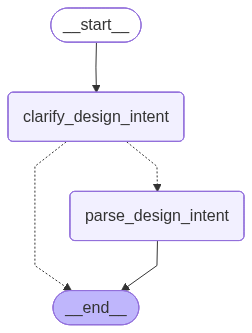

In [36]:
from langgraph.checkpoint.memory import InMemorySaver
from IPython.display import Image, display

from cad_agent_from_scratch.design_intent_workflow import builder

checkpointer = InMemorySaver()

scope = builder.compile(checkpointer=checkpointer)
display(Image(scope.get_graph(xray=True).draw_mermaid_png()))

In [37]:
# Run the CAD design intention workflow
from langchain_core.messages import HumanMessage
from utils import format_messages

# Thread config
thread = {"configurable": {"thread_id": "7"}}

# Invoke
result = scope.invoke(
    {"messages": [HumanMessage(content="Design a simple cube")]},
    config=thread
)

# Display messages
format_messages(result["messages"])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Design a simple cube                                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ What should be the approximate size of the cube (e.g., edge length in mm, cm, or inches)? Is the cube meant to  │
│ be solid or hollow?                                                                                             │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [38]:
result = scope.invoke(
    {
        "messages": [
            HumanMessage(
                content="Make it a solid cube with a side length of about 50 units. No specific material or finish required."
            )
        ]
    },
    config=thread
)

format_messages(result["messages"])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Design a simple cube                                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ What should be the approximate size of the cube (e.g., edge length in mm, cm, or inches)? Is the cube meant to  │
│ be solid or hollow?                                                                                             │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Make it a solid cube with a side length of about 50 units. No specific material or finish required.             │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Design a solid cube with a side length of approximately 50 units. No specific material or finish is required.   │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [39]:
parsed = result.get("parsed_intent")

print(parsed)

{'object_name': 'cube', 'components': ['cube'], 'dimensions': {'side length': 'approximately 50 units'}, 'configuration': 'solid', 'assumptions': None}


We can inspect the execution of the design intention workflow using **LangSmith traces**, which provide visibility into each LangGraph node execution, state updates, and LLM calls.

https://smith.langchain.com/public/54d26507-dd2a-4c9f-9f1a-ddcc8db1749b/r

---

## Local Deployment and LangGraph Studio (CAD Agent)

LangGraph is designed to seamlessly support **local and production deployment** of agentic workflows.

The files generated using `%%writefile` during this notebook form the **core CAD Agent application**, specifically implementing **Step-1: Design Intention Clarification and Parsing**.

The resulting project structure looks like this:

```
cad_agent_from_scratch/
├── src/cad_agent_from_scratch/
│   ├── design_intent_state.py    # State & schemas for CAD intent
│   ├── design_intent_workflow.py    # Intention clarification + parsing workflow
│   ├── prompts.py                # CAD-specific prompt templates
│   └── ...
├── notebooks/                    # Development notebooks (source of truth)
├── pyproject.toml                # Dependencies and environment setup
└── langgraph.json                # LangGraph configuration
```

### What this enables

* The **notebooks** are used for iterative development and experimentation
* The **`src/` directory** contains deployable LangGraph workflows
* The **design intention workflow** can be:

  * Tested locally
  * Run as a service
  * Extended with downstream CAD agents (constraint parsing, geometry planning, code generation)

---

## LangGraph Configuration

The repository includes a `langgraph.json` file that specifies:

* Which graphs are exposed
* Required dependencies
* Environment variables (e.g., API keys)
* Entry points for LangGraph Studio and servers

This setup allows the **CAD design intention workflow** to be deployed:

* Locally for debugging
* As a backend service for a CAD UI
* As part of a larger multi-agent CAD system


---

## Running LangGraph Studio Locally

From the **root of the CAD Agent repository**, you can start a local LangGraph server and open **LangGraph Studio** in your browser using:

```bash
uvx --refresh --from "langgraph-cli[inmem]" --with-editable . --python 3.11 langgraph dev
```

This will:

* Launch a local LangGraph server
* Load your **design intention workflow**
* Allow you to:

  * Visualize the graph
  * Inspect state transitions
  * Replay runs
  * Debug parsing and clarification behavior interactively

---


# Evaluation

Now that we’ve completed **Design Intention Clarification and Parsing**, we can test the workflow with a few example conversations to verify that it behaves as expected.

In a CAD context, a **good clarified and parsed design intent** should satisfy the following:

* It accurately captures **all explicitly stated design decisions** from the user conversation
* It does **not invent geometry, dimensions, components, or configurations**
* It clearly distinguishes between:

  * Explicitly provided information
  * Assumptions (only when unavoidable)
* It produces a **structured output** that can be safely consumed by downstream CAD agents (e.g., constraint parsing, geometry planning)

Below are a few sample input conversations used to evaluate whether the design intention workflow:

1. Asks clarification questions when required
2. Stops clarifying once sufficient information is provided
3. Produces a clean, structured `parsed_intent` without hallucination


In [40]:
from langchain_core.messages import HumanMessage, AIMessage

conversation_1 = [
    HumanMessage(content="I need a simple cube model."),
    AIMessage(content="Sure. Do you have an approximate size in mind, and should it be solid or hollow?"),
    HumanMessage(content="Make it solid, about 50 units on each side."),
]

conversation_2 = [
    HumanMessage(content="Can you design a small cylindrical container?"),
    AIMessage(content="Of course. What dimensions should it have, and should it be solid or hollow?"),
    HumanMessage(content="Hollow. Around 40 units tall and 20 units in diameter."),
]

conversation_3 = [
    HumanMessage(content="I want a simple rectangular box for storage."),
    AIMessage(content="Okay. Do you have approximate dimensions or special features?"),
    HumanMessage(content="No features. Roughly 100 by 60 by 40 units."),
]


conversation_4 = [
    HumanMessage(content="Design a flat square plate."),
    AIMessage(content="Sure. What should the side length and thickness be?"),
    HumanMessage(content="Side length around 80 units. Thickness can be small."),
]


conversation_5 = [
    HumanMessage(content="I need a simple L-shaped bracket."),
    AIMessage(content="Got it. What are the approximate dimensions of each leg?"),
    HumanMessage(content="One side is about 60 units, the other about 40 units."),
]



In [41]:
criteria_1 = [
    "Object is a cube",
    "Cube is solid",
    "Side length is approximately 50 units",
]

criteria_2 = [
    "Object is a cylinder",
    "Object is hollow",
    "Height is approximately 40 units",
    "Diameter is approximately 20 units",
]

criteria_3 = [
    "Object is a rectangular box",
    "Length is approximately 100 units",
    "Width is approximately 60 units",
    "Height is approximately 40 units",
]

criteria_4 = [
    "Object is a square plate",
    "Side length is approximately 80 units",
    "Thickness is specified",
]

criteria_5 = [
    "Object is an L-shaped bracket",
    "Bracket has two perpendicular legs",
    "One leg is approximately 60 units",
    "Other leg is approximately 40 units",
]

In [42]:
import os
from langsmith import Client

langsmith_client = Client(api_key=os.getenv("LANGSMITH_API_KEY"))

dataset_name = "cad_design_intent_evaluation_final"

if not langsmith_client.has_dataset(dataset_name=dataset_name):
    dataset = langsmith_client.create_dataset(
        dataset_name=dataset_name,
        description="Evaluation dataset for CAD design intent clarification and parsing",
    )

    langsmith_client.create_examples(
        dataset_id=dataset.id,
        examples=[
            {
                "inputs": {"messages": conversation_1},
                "outputs": {"criteria": criteria_1},
            },
            {
                "inputs": {"messages": conversation_2},
                "outputs": {"criteria": criteria_2},
            },
            {
                "inputs": {"messages": conversation_3},
                "outputs": {"criteria": criteria_3},
            },
            {
                "inputs": {"messages": conversation_4},
                "outputs": {"criteria": criteria_4},
            },
            {
                "inputs": {"messages": conversation_5},
                "outputs": {"criteria": criteria_5},
            }

        ],
    )

datasets = list(langsmith_client.list_datasets())
ds = next(d for d in datasets if d.name == dataset_name)
print("Dataset object:", ds)


Dataset object: name='cad_design_intent_evaluation_final' description='Evaluation dataset for CAD design intent clarification and parsing' data_type=<DataType.kv: 'kv'> id=UUID('e26fef06-3bb6-4843-9cbe-cc58b76ae246') created_at=datetime.datetime(2025, 12, 18, 16, 31, 3, 584372, tzinfo=datetime.timezone.utc) modified_at=datetime.datetime(2025, 12, 18, 16, 31, 3, 584372, tzinfo=datetime.timezone.utc) example_count=5 session_count=3 last_session_start_time=datetime.datetime(2025, 12, 23, 18, 11, 3, 916851) inputs_schema=None outputs_schema=None transformations=None metadata={'runtime': {'sdk': 'langsmith-py', 'library': 'langsmith', 'runtime': 'python', 'platform': 'Windows-10-10.0.26200-SP0', 'sdk_version': '0.5.0', 'runtime_version': '3.11.9', 'langchain_version': '1.2.0', 'py_implementation': 'CPython', 'langchain_core_version': '1.2.2'}}


In [43]:
from cad_agent_from_scratch.prompts import CAD_CRITERIA_PROMPT
show_prompt(CAD_CRITERIA_PROMPT, "CAD_CRITERIA_PROMPT")

╭────────────────────────────────────────────── CAD_CRITERIA_PROMPT ──────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│  You are a CAD design intent evaluator.                                                                         │
│                                                                                                                 │
│  Your task is to determine whether the parsed design intent                                                     │
│  captures the given criterion.                                                                                  │
│                                                                                                                 │
│  IMPORTANT:                                                                                                     │
│  - Not all criteria apply to all objects.                                                                       │
│  - Missing fields are acceptable if the criterion is not applicable.                                            │
│  - Do NOT penalize the design intent for being unrelated.                                                       │
│                                                                                                                 │
│  Criterion:                                                                                                     │
│  {criterion}                                                                                                    │
│                                                                                                                 │
│  Parsed Design Intent:                                                                                          │
│  {parsed_intent}                                                                                                │
│                                                                                                                 │
│  Evaluation rules:                                                                                              │
│  1. CAPTURED:                                                                                                   │
│     - The criterion is explicitly present, OR                                                                   │
│     - The criterion is clearly implied by the parsed intent                                                     │
│                                                                                                                 │
│  2. NOT CAPTURED:                                                                                               │
│     - The criterion is relevant but missing, OR                                                                 │
│     - The criterion contradicts the parsed intent                                                               │
│                                                                                                                 │
│  3. NOT APPLICABLE (treat as NOT CAPTURED):                                                                     │
│     - The criterion does not apply to the object type                                                           │
│     - Example: airplane criteria for a cube                                                                     │
│                                                                                                                 │
│  Reasoning guidelines:                                                                                          │
│  - First identify the object type                                                                               │
│  - Decide whether the criterion applies               

In [44]:
from pydantic import BaseModel, Field
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage

class CADCriteriaEval(BaseModel):
    criteria_text: str
    reasoning: str
    is_captured: bool

def evaluate_success_criteria(outputs: dict, reference_outputs: dict):
    parsed_intent = outputs["parsed_intent"]
    success_criteria = reference_outputs["criteria"]

    model = ChatOpenAI(model="gpt-4.1-mini", temperature=0)
    structured_model = model.with_structured_output(CADCriteriaEval)

    responses = structured_model.batch([
        [
            HumanMessage(
                content=CAD_CRITERIA_PROMPT.format(
                    criterion=criterion,
                    parsed_intent=str(parsed_intent),
                )
            )
        ]
        for criterion in success_criteria
    ])

    evaluations = [
        CADCriteriaEval(
            criteria_text=criterion,
            reasoning=response.reasoning,
            is_captured=response.is_captured,
        )
        for criterion, response in zip(success_criteria, responses)
    ]

    captured = sum(1 for e in evaluations if e.is_captured)

    return {
        "key": "cad_success_criteria_score",
        "score": captured / len(evaluations),
        "individual_evaluations": [
            {
                "criteria": e.criteria_text,
                "captured": e.is_captured,
                "reasoning": e.reasoning,
            }
            for e in evaluations
        ],
    }


In [45]:
from cad_agent_from_scratch.prompts import CAD_HALLUCINATION_PROMPT
show_prompt(CAD_HALLUCINATION_PROMPT, "CAD_HALLUCINATION_PROMPT")

╭─────────────────────────────────────────── CAD_HALLUCINATION_PROMPT ────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│  You are a CAD design auditor.                                                                                  │
│                                                                                                                 │
│  Check whether the parsed design intent introduces ANY information                                              │
│  not explicitly provided by the user.                                                                           │
│                                                                                                                 │
│  Parsed Design Intent:                                                                                          │
│  {parsed_intent}                                                                                                │
│                                                                                                                 │
│  User-Provided Criteria:                                                                                        │
│  {success_criteria}                                                                                             │
│                                                                                                                 │
│  PASS if:                                                                                                       │
│  - No unstated dimensions, geometry, or components are introduced                                               │
│  - Any assumptions are explicitly labeled                                                                       │
│                                                                                                                 │
│  FAIL if:                                                                                                       │
│  - New features, sizes, or configurations are invented                                                          │
│  - Design choices are narrowed beyond user input                                                                │
│                                                                                                                 │
│  Return values for:                                                                                             │
│  - no_hallucination                                                                                             │
│  - reasoning                                                                                                    │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [46]:
class NoCADAssumptions(BaseModel):
    no_assumptions: bool
    reasoning: str

def evaluate_no_assumptions(outputs: dict, reference_outputs: dict):
    parsed_intent = outputs["parsed_intent"]
    success_criteria = reference_outputs["criteria"]

    model = ChatOpenAI(model="gpt-4.1-mini", temperature=0)
    structured_model = model.with_structured_output(NoCADAssumptions)

    response = structured_model.invoke([
        HumanMessage(
            content=CAD_HALLUCINATION_PROMPT.format(
                parsed_intent=str(parsed_intent),
                success_criteria=str(success_criteria),
            )
        )
    ])

    return {
        "key": "cad_no_assumptions_score",
        "score": response.no_assumptions,
        "reasoning": response.reasoning,
    }

In [47]:
import uuid

def target_func(inputs: dict):
    config = {"configurable": {"thread_id": str(uuid.uuid4())}}
    state = scope.invoke(inputs, config=config)

    # Explicitly expose parsed_intent for evaluators
    return {
        "parsed_intent": state.get("parsed_intent"),
        "design_intent": state.get("design_intent"),
        "messages": state.get("messages"),
    }


langsmith_client.evaluate(
    target_func,
    data=dataset_name,
    evaluators=[evaluate_success_criteria, evaluate_no_assumptions],
    experiment_prefix="CAD Design Intent Evaluation",
)

View the evaluation results for experiment: 'CAD Design Intent Evaluation-313f0ada' at:
https://smith.langchain.com/o/7aa3a156-5909-41ad-a7a3-8ec0e834b081/datasets/e26fef06-3bb6-4843-9cbe-cc58b76ae246/compare?selectedSessions=a315837f-be3b-4f01-addb-28377ef16b2c




0it [00:00, ?it/s]

<ExperimentResults CAD Design Intent Evaluation-313f0ada>